In [1]:
%load_ext autoreload
%autoreload 2
import sys
from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")
ble = get_ble_controller()

2024-04-30 18:28:57,326 | INFO     |: info
2024-04-30 18:28:57,328 | WARNING  |: warning
2024-04-30 18:28:57,329 | ERROR    |: error
2024-04-30 18:28:57,330 | CRITICAL |: critical


In [2]:
ble.connect()

2024-04-30 18:29:01,800 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:89:c1:6d:24:4b
2024-04-30 18:29:06,846 | INFO     |: Connected to c0:89:c1:6d:24:4b


C:\Users\xyx07\Fast_Robot\Webpage\FR-2024\code\Lab8\stunt\base_ble.py:104: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [3]:
raw_message=[]
#add more arrays if needed
num = []
timeIMU = []
yaw = []
yawPWM = []
timeToF = [] 
distanceF = [] 
timePID = []
PIDoutput = []
def clear_data():
    # Clear all the sensor data arrays
    raw_message.clear()
    timeIMU.clear()
    yaw.clear()
    yawPWM.clear()
    distanceF.clear()
    timeToF.clear()
    timePID.clear()
    PIDoutput.clear()
    
def notification_handler(uuid, byte_array):
    global timeIMU,xAcc,yAcc,zAcc,xGyr,yGyr,zGyr
    raw_message.append(byte_array)
    message = ble.bytearray_to_string(byte_array)
    if message=='IMU data received.':
        print(message)
    elif message=='ToF data received.':
        print(message)
    elif message=='PID data received.':
        print(message)
    else: 
        readings = message.split('|')
        num.clear()
        for reading in readings:
            label, value = reading.split(':')
            num.append(float(value))
        if len(readings)==2:
            if label=="Front Distance":
                timeToF.append(num[0]/1000)
                distanceF.append(num[1])
            elif label=="PID output":
                timePID.append(num[0]/1000)
                PIDoutput.append(num[1])
        if len(readings)==3:
                timeIMU.append(num[0]/1000)
                yaw.append(num[1])
                yawPWM.append(num[2])

In [4]:
ble.send_command(CMD.ECHO, "HiHello")
output1 = ble.receive_string(ble.uuid['RX_STRING'])
print(output1)

Robot says -> HiHello :)


In [58]:
spd = 100
speedL = spd-65
speedR = int(spd/1.12)+65
spd = str(speedL)+"|"+str(speedR)
ble.send_command(CMD.MOVE, spd)

In [59]:
ble.send_command(CMD.MOVE, "0|0")

In [5]:
Kp = 0.5
Ki = 0.002
Kd = 0.0
minPWM = 130
maxPWM = 200
maxESum = 4000
yawCorrection = 1.9
cmd = str(Kp)+"|"+str(Ki)+"|"+str(Kd)+"|"+str(minPWM)+"|"+ str(maxPWM)+"|" +str(maxESum)+"|" +str(yawCorrection)
print(cmd)
ble.send_command(CMD.SET_YAW_PID, cmd)

0.5|0.002|0.0|130|200|4000|1.9


In [6]:
Kpl = 0.08
minPWMl = 50
maxPWMl = 180
distance = 914
cmd = str(Kpl)+"|"+str(minPWMl)+"|"+str(maxPWMl)+"|"+str(distance)
print(cmd)
ble.send_command(CMD.SET_LINEAR_PID, cmd)

0.08|50|180|914


In [7]:
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [8]:
clear_data()
ble.send_command(CMD.PID, "4000")

ToF data received.
PID data received.
IMU data received.


In [9]:
ble.stop_notify(ble.uuid['RX_STRING'])

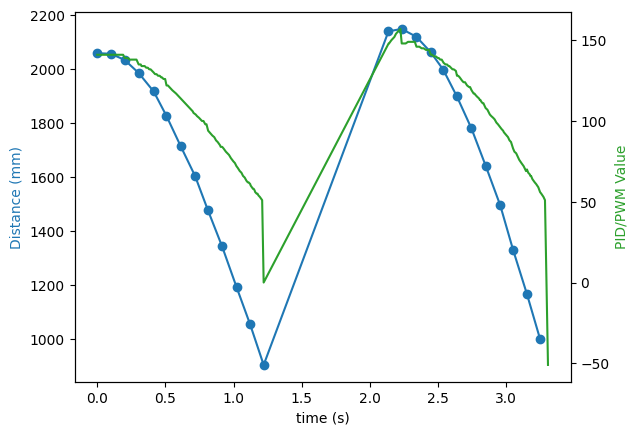

In [10]:
fig, ax1 = plt.subplots() 
color = 'tab:blue'
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('Distance (mm)', color = color) 
ax1.scatter(np.array(timeToF)-timeToF[0], distanceF, color=color)
ax1.plot(np.array(timeToF)-timeToF[0], distanceF, color=color)
ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('PID/PWM Value', color = color) 
ax2.plot(np.array(timePID)-timeToF[0], PIDoutput, label = 'PID/PWM Value',color=color)
plt.show();

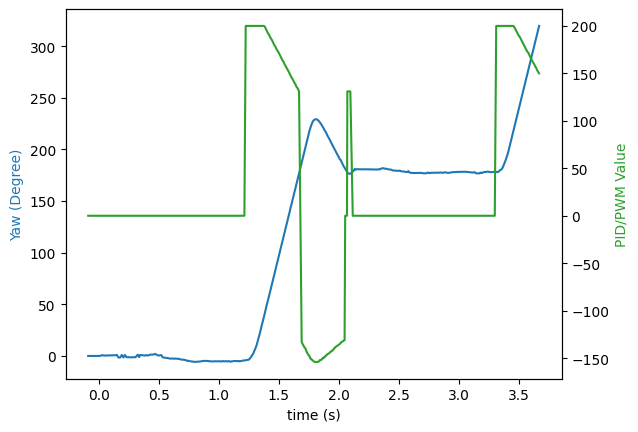

In [12]:
fig, ax1 = plt.subplots() 
color = 'tab:blue'
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('Yaw (Degree)', color = color) 
ax1.plot(np.array(timeIMU)-timeToF[0], yaw, color=color)
ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('PID/PWM Value', color = color) 
ax2.plot(np.array(timeIMU)-timeToF[0], yawPWM, label = 'PID/PWM Value',color=color)
plt.show();

In [13]:
data1 = {
    "Time": timeIMU,
    "Yaw": yaw,
    "YawPWM": yawPWM
}
data2 = {
    "Time": timeToF,
    "Distance": distanceF,
}

data3 = {
    "Time": timePID,
    "DistPWM": PIDoutput,
}

# The filename for the CSV
csv_filename1 = 'OPID.csv'
csv_filename2 = 'Dist.csv'
csv_filename3 = 'LPID.csv'

with open(csv_filename1, mode='w') as file:
    file.write(','.join(data1.keys()) + '\n')
    for i in range(len(data1["Time"])):
        file.write(f'{data1["Time"][i]},{data1["Yaw"][i]},{data1["YawPWM"][i]}\n')

with open(csv_filename2, mode='w') as file:
    file.write(','.join(data2.keys()) + '\n')
    for i in range(len(data2["Time"])):
        file.write(f'{data2["Time"][i]},{data2["Distance"][i]}\n')

with open(csv_filename3, mode='w') as file:
    file.write(','.join(data3.keys()) + '\n')
    for i in range(len(data3["Time"])):
        file.write(f'{data3["Time"][i]},{data3["DistPWM"][i]}\n')

2024-04-30 20:14:37,913 | INFO     |: Disconnected from C0:89:C1:6D:24:4B


It takes: 4.847s to collect data.
Sample rate is about 89 samples/s.


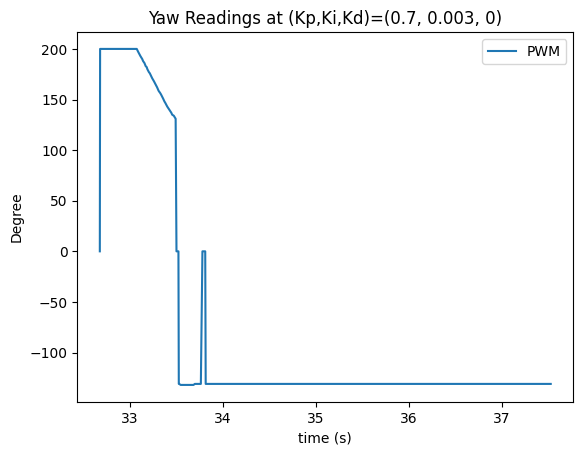

In [52]:
plt.plot(timeIMU, yaw, label = 'Yaw Angle')
plt.plot(timeIMU, yawPWM, label = 'PWM')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();
print(f"It takes: {round(timeIMU[-1]-timeIMU[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeIMU)/(timeIMU[-1]-timeIMU[0]))} samples/s.")

In [43]:
yawPWM

[0.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 199.0,
 198.0,
 197.0,
 196.0,
 193.0,
 190.0,
 188.0,
 187.0,
 185.0,
 182.0,
 179.0,
 177.0,
 176.0,
 173.0,
 171.0,
 169.0,
 167.0,
 165.0,
 163.0,
 161.0,
 158.0,
 157.0,
 156.0,
 154.0,
 153.0,
 151.0,
 149.0,
 147.0,
 145.0,
 142.0,
 140.0,
 139.0,
 138.0,
 136.0,
 135.0,
 134.0,
 133.0,
 131.0,
 131.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -131.0,
 -131.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

2024-04-30 12:09:55,315 | INFO     |: Disconnected from C0:89:C1:6D:24:4B


It takes: 3.003s to collect data.
Sample rate is about 183 samples/s.


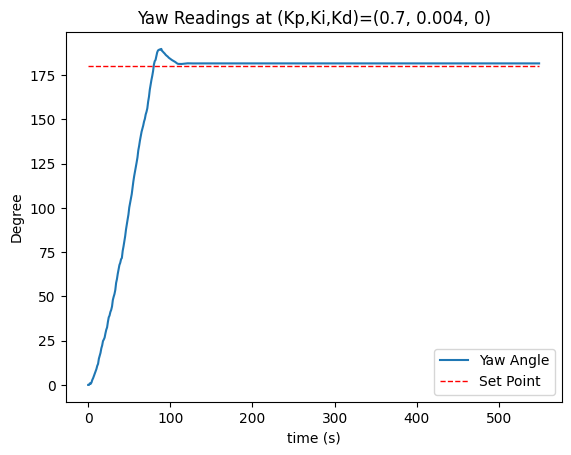

In [24]:
plt.plot(yaw, label = 'Yaw Angle')
plt.plot(setYaw, label = 'Set Point', color='r', lw = 1, ls='--')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();
print(f"It takes: {round(timeIMU[-1]-timeIMU[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeIMU)/(timeIMU[-1]-timeIMU[0]))} samples/s.")

It takes: 7.999s to collect data.
Sample rate is about 153 samples/s.


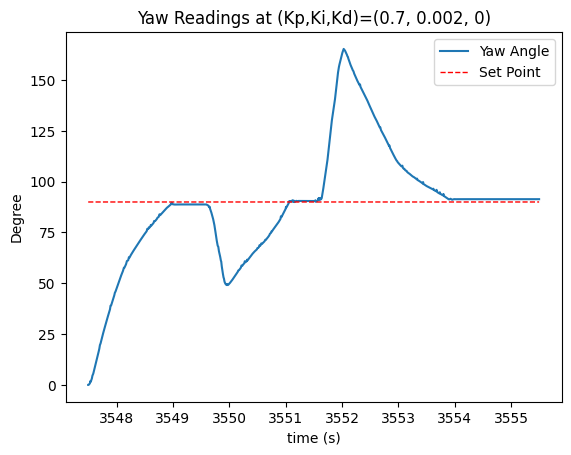

In [178]:
plt.plot(timeIMU,yaw, label = 'Yaw Angle')
plt.plot(timeIMU,setYaw, label = 'Set Point', color='r', lw = 1, ls='--')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();
print(f"It takes: {round(timeIMU[-1]-timeIMU[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeIMU)/(timeIMU[-1]-timeIMU[0]))} samples/s.")

It takes: 3.0s to collect data.
Sample rate is about 205 samples/s.


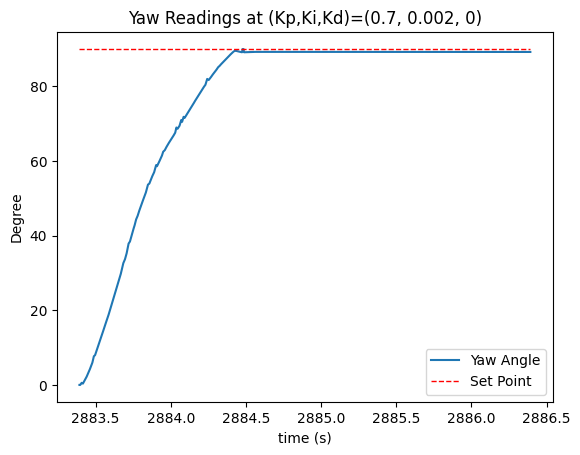

In [154]:
plt.plot(timeIMU,yaw, label = 'Yaw Angle')
plt.plot(timeIMU,setYaw, label = 'Set Point', color='r', lw = 1, ls='--')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();
print(f"It takes: {round(timeIMU[-1]-timeIMU[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeIMU)/(timeIMU[-1]-timeIMU[0]))} samples/s.")

It takes: 8.002s to collect data.
Sample rate is about 102 samples/s.


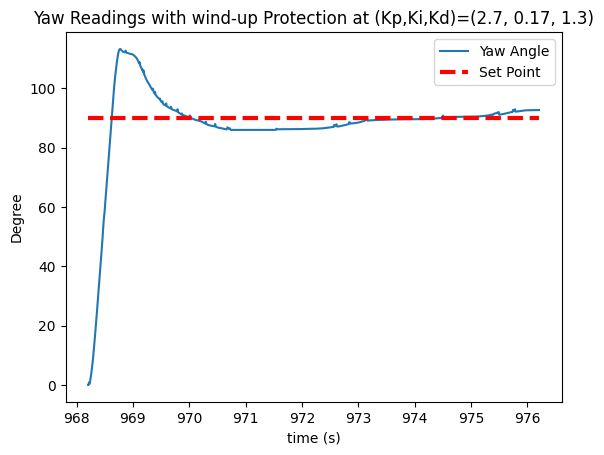

In [45]:
plt.plot(timeIMU,yaw, label = 'Yaw Angle')
plt.plot(timeIMU,setYaw, label = 'Set Point', color='r', lw = 3, ls='--')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings with wind-up Protection at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();
print(f"It takes: {round(timeIMU[-1]-timeIMU[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeIMU)/(timeIMU[-1]-timeIMU[0]))} samples/s.")

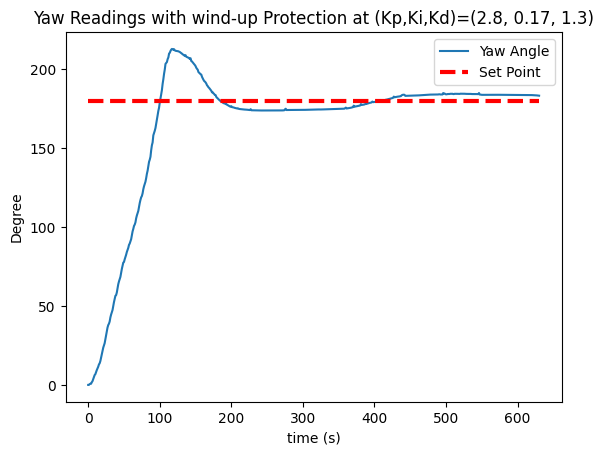

In [70]:
plt.plot(yaw, label = 'Yaw Angle')
plt.plot(setYaw, label = 'Set Point', color='r', lw = 3, ls='--')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings with wind-up Protection at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();


In [237]:
yaw[-100]

87.115

It takes: 4.005s to collect data.
Sample rate is about 104 samples/s.


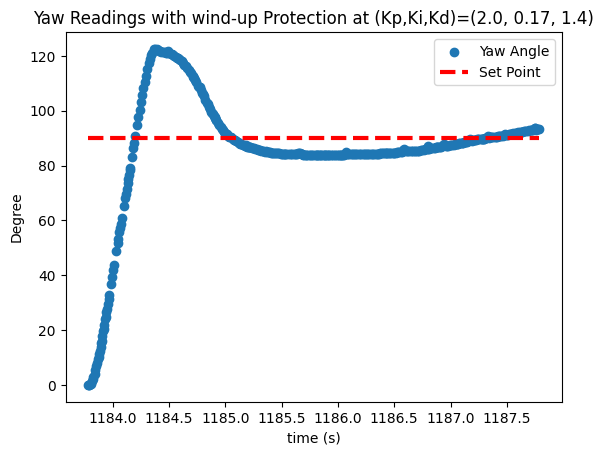

In [211]:
plt.scatter(timeIMU,yaw, label = 'Yaw Angle')
plt.plot(timeIMU,setYaw, label = 'Set Point', color='r', lw = 3, ls='--')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings with wind-up Protection at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();
print(f"It takes: {round(timeIMU[-1]-timeIMU[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeIMU)/(timeIMU[-1]-timeIMU[0]))} samples/s.")

It takes: 4.001s to collect data.
Sample rate is about 101 samples/s.


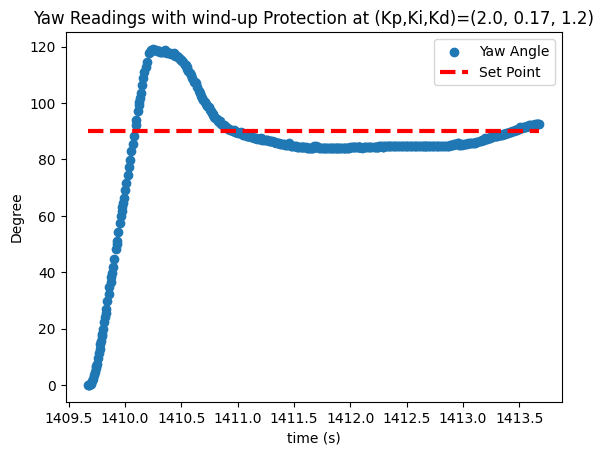

In [231]:
plt.scatter(timeIMU,yaw, label = 'Yaw Angle')
plt.plot(timeIMU,setYaw, label = 'Set Point', color='r', lw = 3, ls='--')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings with wind-up Protection at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();
print(f"It takes: {round(timeIMU[-1]-timeIMU[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeIMU)/(timeIMU[-1]-timeIMU[0]))} samples/s.")

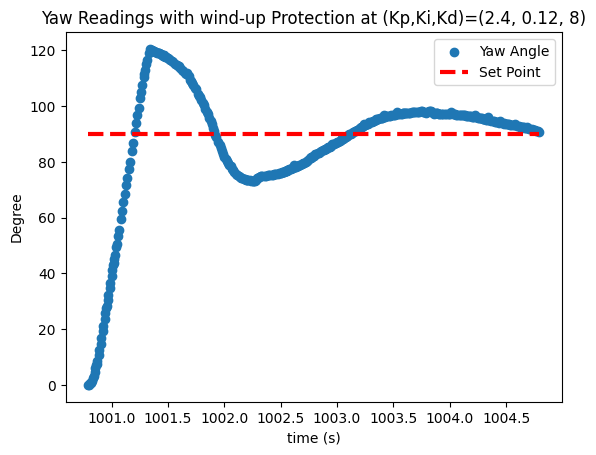

In [77]:
plt.scatter(timeIMU,yaw, label = 'Yaw Angle')
plt.plot(timeIMU,setYaw, label = 'Set Point', color='r', lw = 3, ls='--')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings with wind-up Protection at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();

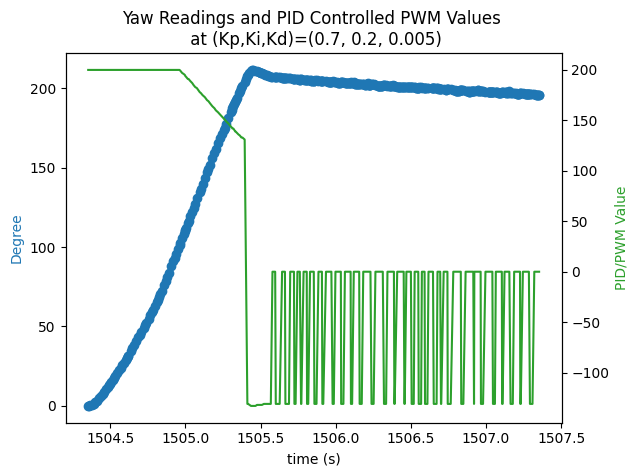

In [102]:
fig, ax1 = plt.subplots() 
color = 'tab:blue'
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('Degree', color = color) 
ax1.scatter(timeIMU,yaw, label = 'Yaw Angle', color=color)
ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('PID/PWM Value', color = color) 
ax2.plot(timeIMU,yawPWM, label = 'PID/PWM Value',color=color)
plt.title('Yaw Readings and PID Controlled PWM Values \n at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.show();

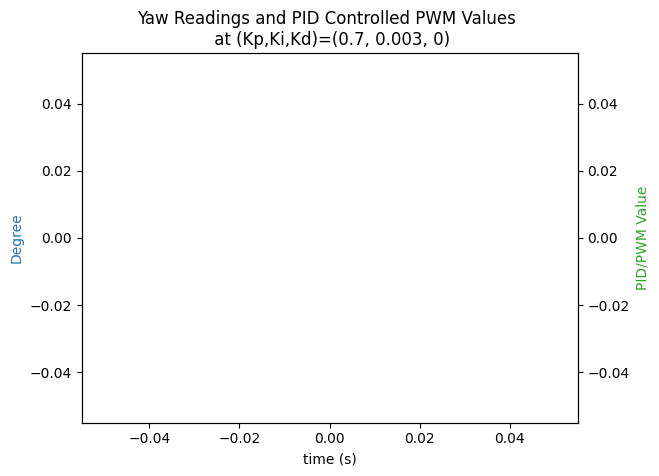

In [49]:
fig, ax1 = plt.subplots() 
color = 'tab:blue'
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('Degree', color = color) 
ax1.plot(yaw, label = 'Yaw Angle', color=color)
ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('PID/PWM Value', color = color) 
ax2.plot(yawPWM, label = 'PID/PWM Value',color=color)
plt.title('Yaw Readings and PID Controlled PWM Values \n at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.show();

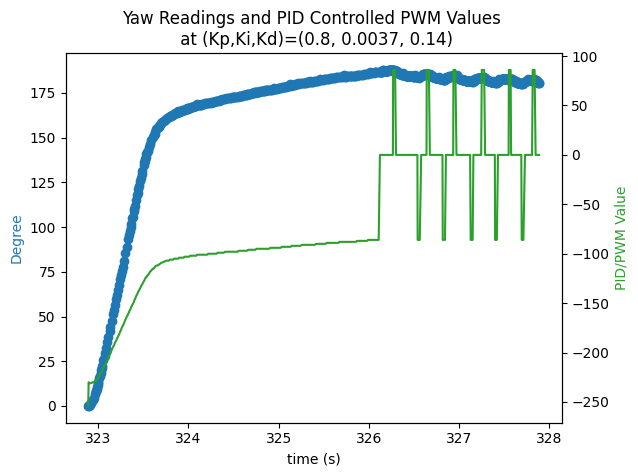

In [117]:
fig, ax1 = plt.subplots() 
color = 'tab:blue'
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('Degree', color = color) 
ax1.scatter(timeIMU,yaw, label = 'Yaw Angle', color=color)
ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('PID/PWM Value', color = color) 
ax2.plot(timeIMU,yawPWM, label = 'PID/PWM Value',color=color)
plt.title('Yaw Readings and PID Controlled PWM Values \n at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.show();

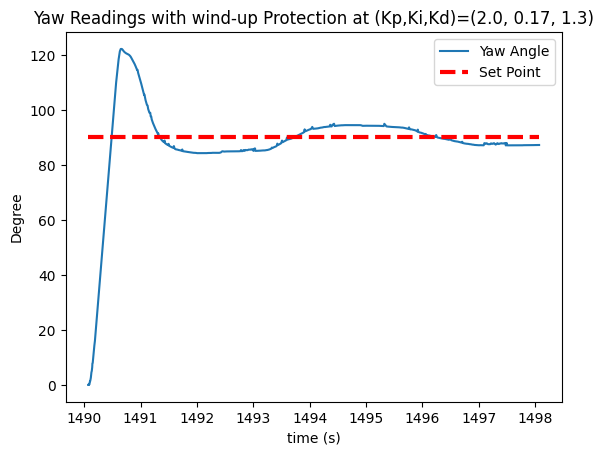

In [238]:
plt.plot(timeIMU,yaw, label = 'Yaw Angle')
plt.plot(timeIMU,setYaw, label = 'Set Point', color='r', lw = 3, ls='--')
plt.xlabel('time (s)')
plt.ylabel('Degree')
plt.title('Yaw Readings with wind-up Protection at (Kp,Ki,Kd)=('+str(Kp)+", "+str(Ki)+", "+str(Kd)+")")
plt.legend();

In [58]:
clear_data()
ble.send_command(CMD.ORIENT_PID, "3000")

IMU data received.
IMU data received.


In [57]:
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)


In [49]:
print(f"It takes: {round(timeIMU[-1]-timeIMU[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeIMU)/(timeIMU[-1]-timeIMU[0]))} samples/s.")

It takes: 3.005s to collect data.
Sample rate is about 272 samples/s.


In [165]:
yaw[-1]

179.339

In [53]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [24]:
# Disconnect
ble.disconnect()

2024-03-13 16:25:17,601 | INFO     |: Disconnected from C0:89:C1:6D:24:4B
